## Сегментация изображений клеток

Вам предстоит обучить модель сегментировать изображения с дрожжевыми клетками и микроструктурами (см. [06_segmentation.ipynb](../workshops/06_segmentation.ipynb)), по пути поэкспериментировав с разными архитектурами и функцими ошибки.

### Задание 1 (2 балл). Метрики сегментации
Перед экспериментами нужно определиться с метриками. Выберите 3-5 метрик, по которым вы будете оценивать качество модели. В этом задании объясните свой выбор и найдите нужные метрики в `torchvision` (а если их нет - реализуйте самостоятельно, здесь вам может помочь [05_lightning_etc.ipynb](../workshops/05_lightning_etc.ipynb))

In [12]:
from __future__ import annotations
#! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
#! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset
! pip install lightning


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
from __future__ import annotations
import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
from torchmetrics import JaccardIndex# Коэффициент перекрытия (Intersection over Union, IoU)
from torchmetrics import Dice # Коэффициент Дайса (Dice Coefficient)
from torchmetrics import Recall # Полнота (Recall)
from torchmetrics import Precision # Точность (Precision)

Пять метрик мне кажутся избыточными и могут усложнять анализ, а три могут не дать полной картины. Поэтому выберем золотую середину - 4.

Первая метрика — IoU (Intersection over Union). Это классическая метрика для оценки сегментации, показывающая степень пересечения предсказанной маски с реальной. Она отражает, насколько точно модель определяет области интереса, и широко используется в компьютерном зрении.

Вторая метрика — коэффициент Дайса (Dice Coefficient). Он похож на IoU, но является более чувствительным, особенно при работе с небольшими объектами, что важно для сегментации дрожжевых клеток и микроструктур. Коэфф. Дайса учитывает площади предсказанных и реальных масок, а в числителе использует удвоенное пересечение. Эта метрика часто применяется в биомедицинских задачах и известна своей точностью.

Третья метрика — полнота (Recall). Полнота показывает, какую долю реальных положительных пикселей модель смогла правильно обнаружить. В нашей задаче важно не пропустить ни одну клетку или микроструктуру, поэтому высокая полнота свидетельствует о способности модели находить все нужные объекты.

Четвёртая метрика — точность (Precision). Точность отражает, какая доля предсказанных моделью положительных пикселей действительно является положительными. Это важно для уменьшения количества ложных срабатываний, что повышает доверие к результатам модели.

Таким образом, IoU и коэффициент Дайса дают представление о качестве перекрытия масок, а полнота и точность помогают понять баланс между обнаружением всех объектов и минимизацией ложных срабатываний. Это обеспечивает глубокий анализ модели без излишней сложности.


### Задание 2 (4 балла). Обучение модели
Возьмите модель и датасеты из практики по сегментации и запустите обучение.

Указания:
- Каждую эпоху сохраняйте значения ошибки и выбранные в задании 1 метрики как для обучающего датасета (`train`), так и для валидационного (`val`).
- Каждую эпоху сохраняйте примеры работы модели на 8 случайных изображениях из валидационного датасета (одной картинкой, как в практике).
- После окончания обучения выведите графики значений ваших метрик и примеры предсказаний (достаточно 4-5 изображений: для первой эпохи, 2-3 в середине обучения и ндля последней эпохи).
- Можете использовать `lightning` (вместо `lightning.pytorch.loggers.TensorBoardLogger` можно использовать `lightning.pytorch.loggers.CSVLogger`, а сохранение изображений можете реализовать как `lightning.pytorch.Callback`), а можете всё написать вручную.

In [3]:
from torch.utils.data import DataLoader
from lightning.pytorch.utilities.types import EVAL_DATALOADERS
from typing import Callable, Any
from torch import Tensor, nn

class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(
            0
        )  # (W, H) -> (1, W, H)
        classes = (
            torch.load(
                self.subset_dir / "classes" / image_path.name, weights_only=True
            )
            + 1
        )  # 0 класс - фон
        masks = torch.load(
            self.subset_dir / "instances" / image_path.name, weights_only=True
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.name, weights_only=True
        )
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)
    
class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пикселя указан класс
        mask = (
            (annotation["masks"] * annotation["labels"].view(-1, 1, 1)).sum(dim=0)
        ).long()

        return image, mask

# DataModule
_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]

class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

# Определение модели U-Net
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)
    

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
        self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/tsagoll/ML_Last_HW/pythonProject3/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Saved prediction examples for epoch 0 at validation_examples/epoch_0.png


/Users/tsagoll/ML_Last_HW/pythonProject3/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/tsagoll/ML_Last_HW/pythonProject3/.venv/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 37: 'val_Dice' reached 0.80770 (best 0.80770), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=0.ckpt' as top 5
Epoch 0, global step 37: 'val_IoU' reached 0.69640 (best 0.69640), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=0.ckpt' as top 5


Saved prediction examples for epoch 0 at validation_examples/epoch_0.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 74: 'val_Dice' reached 0.91224 (best 0.91224), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=1.ckpt' as top 5
Epoch 1, global step 74: 'val_IoU' reached 0.84332 (best 0.84332), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=1.ckpt' as top 5


Saved prediction examples for epoch 1 at validation_examples/epoch_1.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 111: 'val_Dice' reached 0.89894 (best 0.91224), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=2.ckpt' as top 5
Epoch 2, global step 111: 'val_IoU' reached 0.82428 (best 0.84332), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=2.ckpt' as top 5


Saved prediction examples for epoch 2 at validation_examples/epoch_2.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 148: 'val_Dice' reached 0.86395 (best 0.91224), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=3.ckpt' as top 5
Epoch 3, global step 148: 'val_IoU' reached 0.76825 (best 0.84332), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=3.ckpt' as top 5


Saved prediction examples for epoch 3 at validation_examples/epoch_3.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 185: 'val_Dice' reached 0.92374 (best 0.92374), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=4.ckpt' as top 5
Epoch 4, global step 185: 'val_IoU' reached 0.86109 (best 0.86109), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=4.ckpt' as top 5


Saved prediction examples for epoch 4 at validation_examples/epoch_4.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 222: 'val_Dice' reached 0.94035 (best 0.94035), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=5.ckpt' as top 5
Epoch 5, global step 222: 'val_IoU' reached 0.88896 (best 0.88896), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=5.ckpt' as top 5


Saved prediction examples for epoch 5 at validation_examples/epoch_5.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 259: 'val_Dice' reached 0.94177 (best 0.94177), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=6.ckpt' as top 5
Epoch 6, global step 259: 'val_IoU' reached 0.89148 (best 0.89148), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=6.ckpt' as top 5


Saved prediction examples for epoch 6 at validation_examples/epoch_6.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 296: 'val_Dice' reached 0.94141 (best 0.94177), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=7.ckpt' as top 5
Epoch 7, global step 296: 'val_IoU' reached 0.89073 (best 0.89148), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=7.ckpt' as top 5


Saved prediction examples for epoch 7 at validation_examples/epoch_7.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 333: 'val_Dice' reached 0.94304 (best 0.94304), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=8.ckpt' as top 5
Epoch 8, global step 333: 'val_IoU' reached 0.89365 (best 0.89365), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=8.ckpt' as top 5


Saved prediction examples for epoch 8 at validation_examples/epoch_8.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 370: 'val_Dice' reached 0.94605 (best 0.94605), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=9.ckpt' as top 5
Epoch 9, global step 370: 'val_IoU' reached 0.89893 (best 0.89893), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=9.ckpt' as top 5


Saved prediction examples for epoch 9 at validation_examples/epoch_9.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 407: 'val_Dice' reached 0.94576 (best 0.94605), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=10.ckpt' as top 5
Epoch 10, global step 407: 'val_IoU' reached 0.89844 (best 0.89893), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=10.ckpt' as top 5


Saved prediction examples for epoch 10 at validation_examples/epoch_10.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 444: 'val_Dice' reached 0.94587 (best 0.94605), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=11.ckpt' as top 5
Epoch 11, global step 444: 'val_IoU' reached 0.89864 (best 0.89893), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=11.ckpt' as top 5


Saved prediction examples for epoch 11 at validation_examples/epoch_11.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 481: 'val_Dice' reached 0.94658 (best 0.94658), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=12.ckpt' as top 5
Epoch 12, global step 481: 'val_IoU' reached 0.89992 (best 0.89992), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=12.ckpt' as top 5


Saved prediction examples for epoch 12 at validation_examples/epoch_12.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 518: 'val_Dice' reached 0.94634 (best 0.94658), saving model to 'logs/segmentation_model/version_23/checkpoints/best-dice-epoch=13.ckpt' as top 5
Epoch 13, global step 518: 'val_IoU' reached 0.89951 (best 0.89992), saving model to 'logs/segmentation_model/version_23/checkpoints/best-iou-epoch=13.ckpt' as top 5


Saved prediction examples for epoch 13 at validation_examples/epoch_13.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 555: 'val_Dice' was not in top 5
Epoch 14, global step 555: 'val_IoU' was not in top 5
`Trainer.fit` stopped: `max_epochs=15` reached.


Saved prediction examples for epoch 14 at validation_examples/epoch_14.png


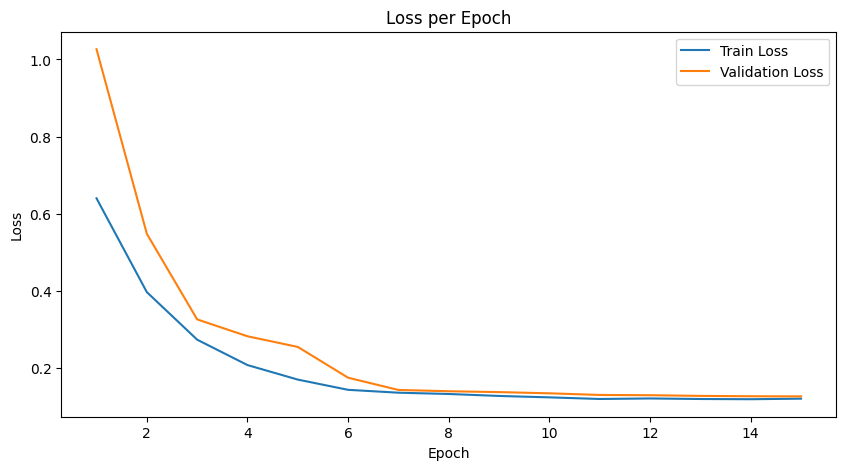

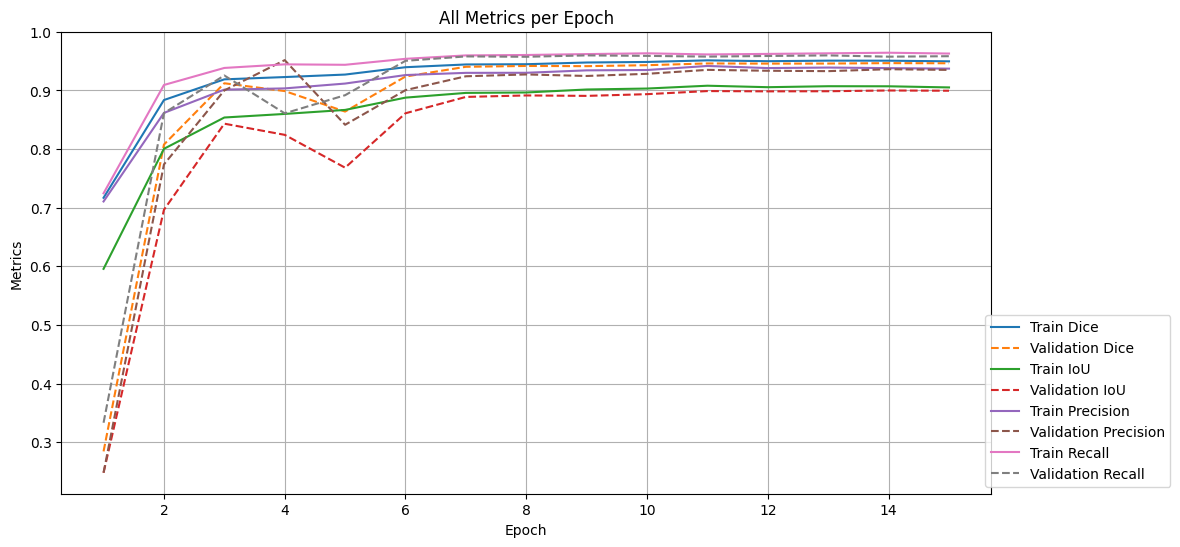

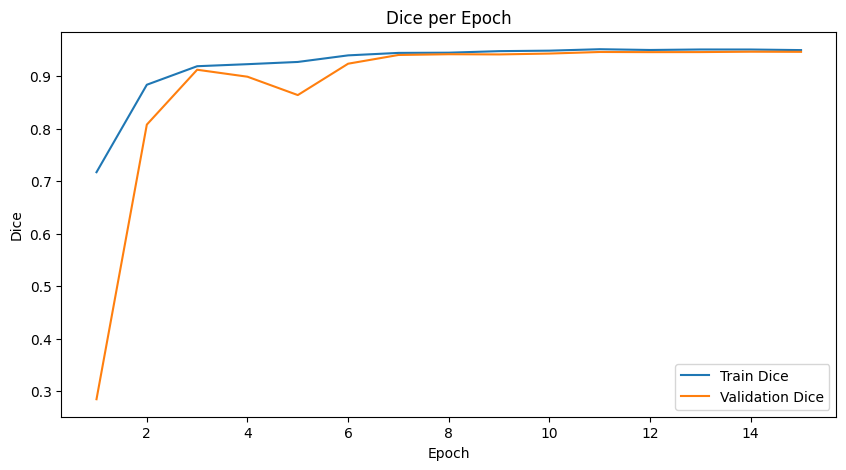

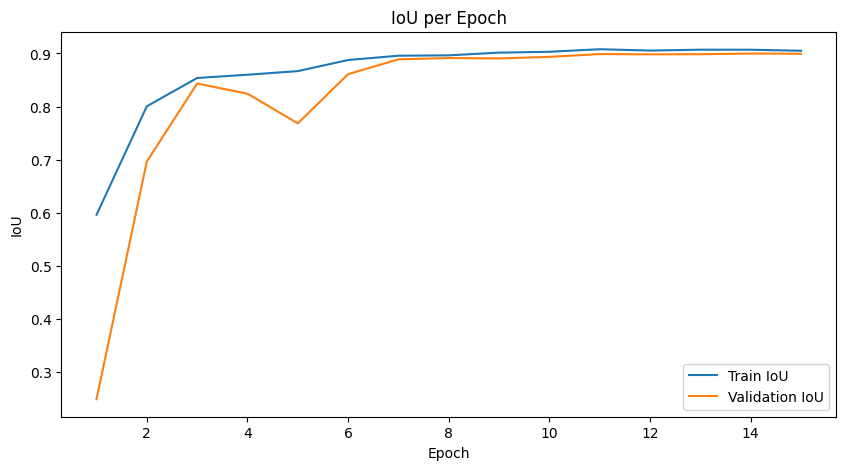

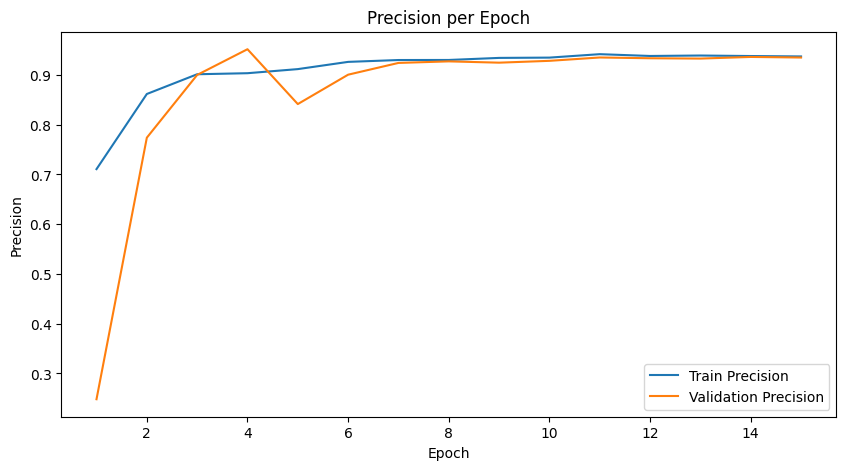

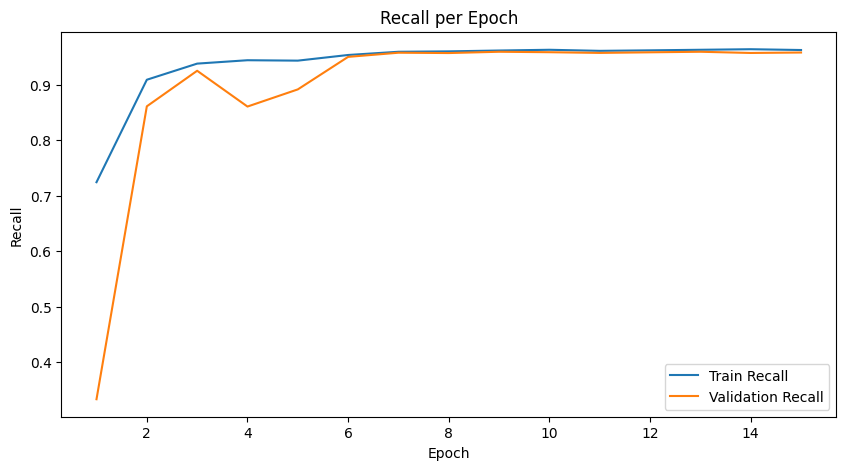

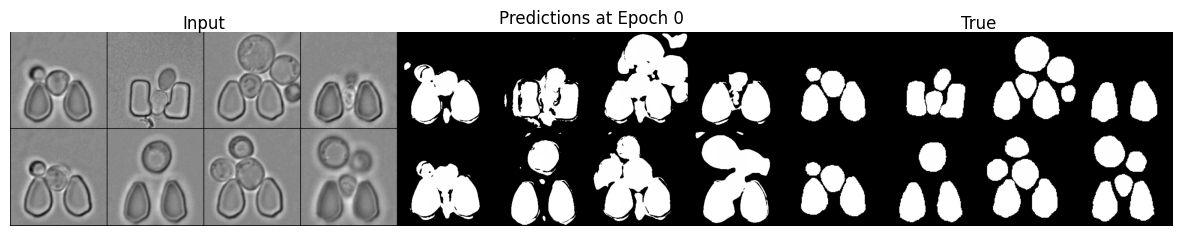

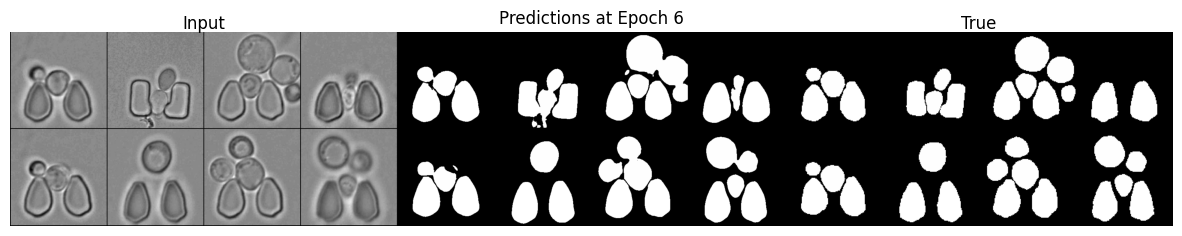

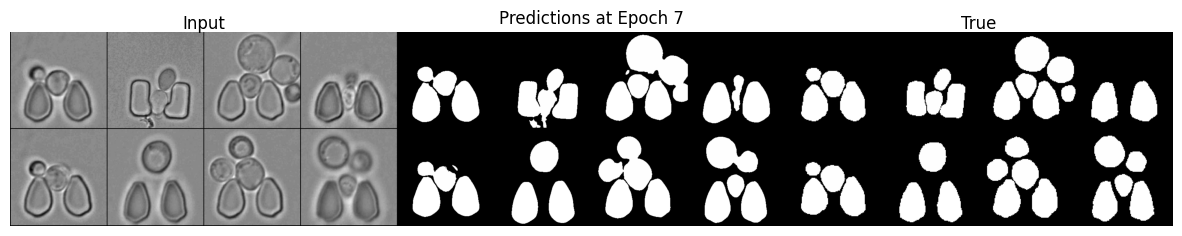

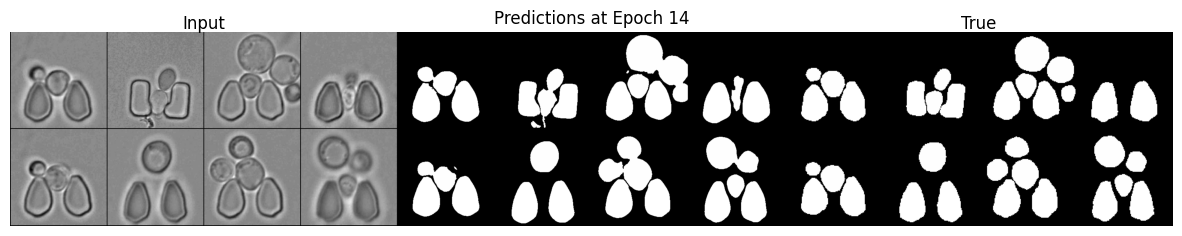

In [17]:
from torchmetrics import MetricCollection

#from torchmetrics import JaccardIndex# Коэффициент перекрытия (Intersection over Union, IoU)
#from torchmetrics import Dice # Коэффициент Дайса (Dice Coefficient)
#from torchmetrics import Recall # Полнота (Recall)
#from torchmetrics import Precision # Точность (Precision)
def create_segmentation_metrics(num_classes:int ):
     return MetricCollection({
        "IoU": JaccardIndex(task="multiclass", num_classes=num_classes),
        "Dice": Dice(num_classes=num_classes, average="macro"),
        "Precision": Precision(task="multiclass", num_classes=num_classes, average="macro"),
        "Recall": Recall(task="multiclass", num_classes=num_classes, average="macro"),
    })

torch.manual_seed(42)

from torchmetrics import MetricCollection, JaccardIndex, Dice, Precision, Recall
import lightning as L
import matplotlib.pyplot as plt
from PIL import Image
import os

class SavePredictionExamplesCallback(L.Callback):
    def __init__(self, num_samples: int = 8, save_dir: str = 'validation_examples'):
        super().__init__()
        self.num_samples = num_samples
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.transform = transforms.ToPILImage()

    def on_validation_epoch_end(self, trainer: L.Trainer, pl_module: L.LightningModule):

        images, preds, masks = getattr(pl_module, 'val_examples', (None, None, None))
        if images is None:
            return

        num_samples = min(self.num_samples, images.size(0))
        images = images[:num_samples]
        preds = preds[:num_samples]
        masks = masks[:num_samples]

        image_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
        preds_grid = torchvision.utils.make_grid(preds.unsqueeze(1).float(), nrow=4, normalize=False)
        masks_grid = torchvision.utils.make_grid(masks.unsqueeze(1).float(), nrow=4, normalize=False)

        image_grid = self.transform(image_grid)
        preds_grid = self.transform(preds_grid)
        masks_grid = self.transform(masks_grid)

        total_width = image_grid.width * 3
        max_height = image_grid.height
        combined_image = Image.new('RGB', (total_width, max_height))
        combined_image.paste(image_grid, (0, 0))
        combined_image.paste(preds_grid.convert('RGB'), (image_grid.width, 0))
        combined_image.paste(masks_grid.convert('RGB'), (image_grid.width * 2, 0))

        epoch = trainer.current_epoch
        output_path = os.path.join(self.save_dir, f'epoch_{epoch}.png')
        combined_image.save(output_path)
        print(f"Saved prediction examples for epoch {epoch} at {output_path}")
class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float, num_classes: int):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        self.train_metrics = create_segmentation_metrics(num_classes=self.num_classes)
        self.val_metrics = create_segmentation_metrics(num_classes=self.num_classes)

        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.train_epoch_metrics = {k: [] for k in self.train_metrics.keys()}
        self.val_epoch_metrics = {k: [] for k in self.val_metrics.keys()}

        self.val_examples = (None, None, None)  

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = F.cross_entropy(logits, masks)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        preds = logits.argmax(dim=1)
        self.train_metrics.update(preds, masks)

        return loss

    def on_train_epoch_end(self):
        metrics = self.train_metrics.compute()
        for k, v in metrics.items():
            self.log(f'train_{k}', v, on_step=False, on_epoch=True)
            self.train_epoch_metrics[k].append(v.cpu().detach().numpy())
        self.train_metrics.reset()

        avg_loss = self.trainer.callback_metrics.get('train_loss', torch.tensor(0.0)).item()
        self.train_epoch_losses.append(avg_loss)

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = F.cross_entropy(logits, masks)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        preds = logits.argmax(dim=1)
        self.val_metrics.update(preds, masks)

        if batch_idx == 0:
            self.val_examples = (images.cpu(), preds.cpu(), masks.cpu())

        return loss

    def on_validation_epoch_end(self):
        metrics = self.val_metrics.compute()
        for k, v in metrics.items():
            self.log(f'val_{k}', v, on_step=False, on_epoch=True)
            self.val_epoch_metrics[k].append(v.cpu().detach().numpy())
        self.val_metrics.reset()

        avg_loss = self.trainer.callback_metrics.get('val_loss', torch.tensor(0.0)).item()
        self.val_epoch_losses.append(avg_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[5, 10, 15], gamma=0.1
        )
        return [optimizer], [scheduler]

from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

torch.manual_seed(42)

datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)
datamodule.setup("fit")

model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)

lit_model = Lit(
    model=model,
    learning_rate=0.001,
    num_classes=3
)

logger = CSVLogger(save_dir='logs/', name='segmentation_model')

checkpoint_dice = ModelCheckpoint(
    monitor="val_Dice",
    mode="max",
    save_top_k=5,
    filename="best-dice-{epoch}",
    verbose=True
)

checkpoint_iou = ModelCheckpoint(
    monitor="val_IoU",
    mode="max",
    save_top_k=5,
    filename="best-iou-{epoch}",
    verbose=True
)

save_preds_callback = SavePredictionExamplesCallback(num_samples=8, save_dir='validation_examples')

trainer = L.Trainer(
    accelerator='auto',
    max_epochs=15,
    logger=logger,
    callbacks=[checkpoint_dice, checkpoint_iou, save_preds_callback],
)

trainer.fit(
    model=lit_model,
    datamodule=datamodule,
)

import matplotlib.pyplot as plt
from PIL import Image

def plot_metrics(lit_model):
    num_epochs = len(lit_model.train_epoch_losses)  
    epochs = range(1, num_epochs + 1)  
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lit_model.train_epoch_losses, label='Train Loss')
    plt.plot(epochs, lit_model.val_epoch_losses[:num_epochs], label='Validation Loss')  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    for metric in lit_model.train_epoch_metrics.keys():
        plt.plot(epochs, lit_model.train_epoch_metrics[metric], label=f'Train {metric}')
        plt.plot(epochs, lit_model.val_epoch_metrics[metric][:num_epochs], label=f'Validation {metric}', linestyle='--')  
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title('All Metrics per Epoch')
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0))
    plt.grid(True)
    plt.show()
    
    for metric in lit_model.train_epoch_metrics.keys():
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, lit_model.train_epoch_metrics[metric], label=f'Train {metric}')
        plt.plot(epochs, lit_model.val_epoch_metrics[metric][:num_epochs], label=f'Validation {metric}')  
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} per Epoch')
        plt.legend()
        plt.show()

plot_metrics(lit_model)
def display_prediction_examples(epochs_list, save_dir='validation_examples'):
    for epoch in epochs_list:
        image_path = os.path.join(save_dir, f'epoch_{epoch}.png')
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.figure(figsize=(15, 5))
            plt.axis('off')
            plt.title(f'Predictions at Epoch {epoch}')
            plt.imshow(img)
            img_width = img.width
            plt.text(img_width / 6, -10, 'Input', ha='center', fontsize=12) 
            #plt.text(img_width / 2, -10, 'Predicted', ha='center', fontsize=12)
            plt.text(img_width * 5 / 6, -10, 'True', ha='center', fontsize=12)
            
            plt.show()
        else:
            print(f'Image for epoch {epoch} not found.')

total_epochs = len(lit_model.train_epoch_losses)
mid_epoch = total_epochs // 2
epochs_to_display = [0, mid_epoch - 1, mid_epoch, total_epochs - 1]
epochs_to_display = [epoch for epoch in epochs_to_display if epoch < total_epochs]
display_prediction_examples(epochs_to_display)

### Задание 3 (3 балла). Выбор другой функции ошибки

Полезная ссылка:
https://www.jeremyjordan.me/semantic-segmentation/#loss

Повторите эксперимент из задания 2, но попробуйте модифицировать функцию ошибки:
- (2 балла) учитывайте пиксели на границе объектов с большим весом, как предлагается в статье [U-Net](https://arxiv.org/abs/1505.04597)
- (1 балл) используйте soft Dice loss

Опишите свои наблюдения, что изменилось? Обратите внимание на скорость обучения, визуальные артефакты предсказаний, динамику метрик.


сравним графики:
на ранних эпохах видно, что с введением soft dice’а, улучшилась валидация у Recal, IoU, Dice(сильно - на 4-5 эпохах можно отчетливо увидеть), стала более стабильной(стабилизировалось поведение, меньше скачков) валидация у Precision,
что поменялось визуально: не знаю как правильно выразиться, но думаю поймете: в версии с soft dice, как мне показалось, мелкие артефакты, которые в обычной реализации были маленькими, и располагались обособлено от остальной предсказанной(белой) части, стали крупнее, а так же соединились с остальной белой частью. т.е. визуально видны более четкие и точные границы, пусть иногда они и ошибочны.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Saved prediction examples for epoch 0 at validation_examples/epoch_0.png


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 37: 'val_Dice' reached 0.85517 (best 0.85517), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=0.ckpt' as top 5
Epoch 0, global step 37: 'val_IoU' reached 0.75886 (best 0.75886), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=0.ckpt' as top 5


Saved prediction examples for epoch 0 at validation_examples/epoch_0.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 74: 'val_Dice' reached 0.89891 (best 0.89891), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=1.ckpt' as top 5
Epoch 1, global step 74: 'val_IoU' reached 0.82000 (best 0.82000), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=1.ckpt' as top 5


Saved prediction examples for epoch 1 at validation_examples/epoch_1.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 111: 'val_Dice' reached 0.91494 (best 0.91494), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=2.ckpt' as top 5
Epoch 2, global step 111: 'val_IoU' reached 0.84700 (best 0.84700), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=2.ckpt' as top 5


Saved prediction examples for epoch 2 at validation_examples/epoch_2.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 148: 'val_Dice' reached 0.93266 (best 0.93266), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=3.ckpt' as top 5
Epoch 3, global step 148: 'val_IoU' reached 0.87635 (best 0.87635), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=3.ckpt' as top 5


Saved prediction examples for epoch 3 at validation_examples/epoch_3.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 185: 'val_Dice' reached 0.93373 (best 0.93373), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=4.ckpt' as top 5
Epoch 4, global step 185: 'val_IoU' reached 0.87845 (best 0.87845), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=4.ckpt' as top 5


Saved prediction examples for epoch 4 at validation_examples/epoch_4.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 222: 'val_Dice' reached 0.94514 (best 0.94514), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=5.ckpt' as top 5
Epoch 5, global step 222: 'val_IoU' reached 0.89749 (best 0.89749), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=5.ckpt' as top 5


Saved prediction examples for epoch 5 at validation_examples/epoch_5.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 259: 'val_Dice' reached 0.94736 (best 0.94736), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=6.ckpt' as top 5
Epoch 6, global step 259: 'val_IoU' reached 0.90140 (best 0.90140), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=6.ckpt' as top 5


Saved prediction examples for epoch 6 at validation_examples/epoch_6.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 296: 'val_Dice' reached 0.94781 (best 0.94781), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=7.ckpt' as top 5
Epoch 7, global step 296: 'val_IoU' reached 0.90223 (best 0.90223), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=7.ckpt' as top 5


Saved prediction examples for epoch 7 at validation_examples/epoch_7.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 333: 'val_Dice' reached 0.94898 (best 0.94898), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=8.ckpt' as top 5
Epoch 8, global step 333: 'val_IoU' reached 0.90423 (best 0.90423), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=8.ckpt' as top 5


Saved prediction examples for epoch 8 at validation_examples/epoch_8.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 370: 'val_Dice' reached 0.94913 (best 0.94913), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=9.ckpt' as top 5
Epoch 9, global step 370: 'val_IoU' reached 0.90456 (best 0.90456), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=9.ckpt' as top 5


Saved prediction examples for epoch 9 at validation_examples/epoch_9.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 407: 'val_Dice' reached 0.94941 (best 0.94941), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=10.ckpt' as top 5
Epoch 10, global step 407: 'val_IoU' reached 0.90504 (best 0.90504), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=10.ckpt' as top 5


Saved prediction examples for epoch 10 at validation_examples/epoch_10.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 444: 'val_Dice' reached 0.94945 (best 0.94945), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=11.ckpt' as top 5
Epoch 11, global step 444: 'val_IoU' reached 0.90510 (best 0.90510), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=11.ckpt' as top 5


Saved prediction examples for epoch 11 at validation_examples/epoch_11.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 481: 'val_Dice' reached 0.95032 (best 0.95032), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=12.ckpt' as top 5
Epoch 12, global step 481: 'val_IoU' reached 0.90662 (best 0.90662), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=12.ckpt' as top 5


Saved prediction examples for epoch 12 at validation_examples/epoch_12.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 518: 'val_Dice' reached 0.95018 (best 0.95032), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=13.ckpt' as top 5
Epoch 13, global step 518: 'val_IoU' reached 0.90638 (best 0.90662), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=13.ckpt' as top 5


Saved prediction examples for epoch 13 at validation_examples/epoch_13.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 555: 'val_Dice' reached 0.94934 (best 0.95032), saving model to 'logs/segmentation_model/version_14/checkpoints/best-dice-epoch=14.ckpt' as top 5
Epoch 14, global step 555: 'val_IoU' reached 0.90491 (best 0.90662), saving model to 'logs/segmentation_model/version_14/checkpoints/best-iou-epoch=14.ckpt' as top 5
`Trainer.fit` stopped: `max_epochs=15` reached.


Saved prediction examples for epoch 14 at validation_examples/epoch_14.png


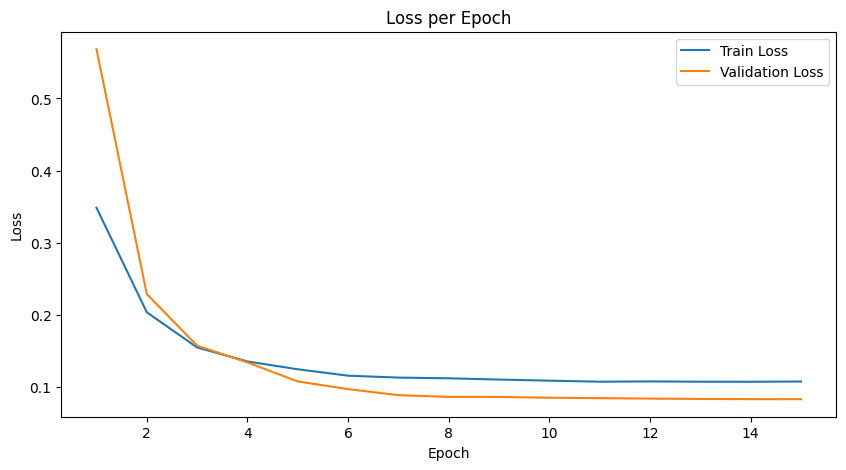

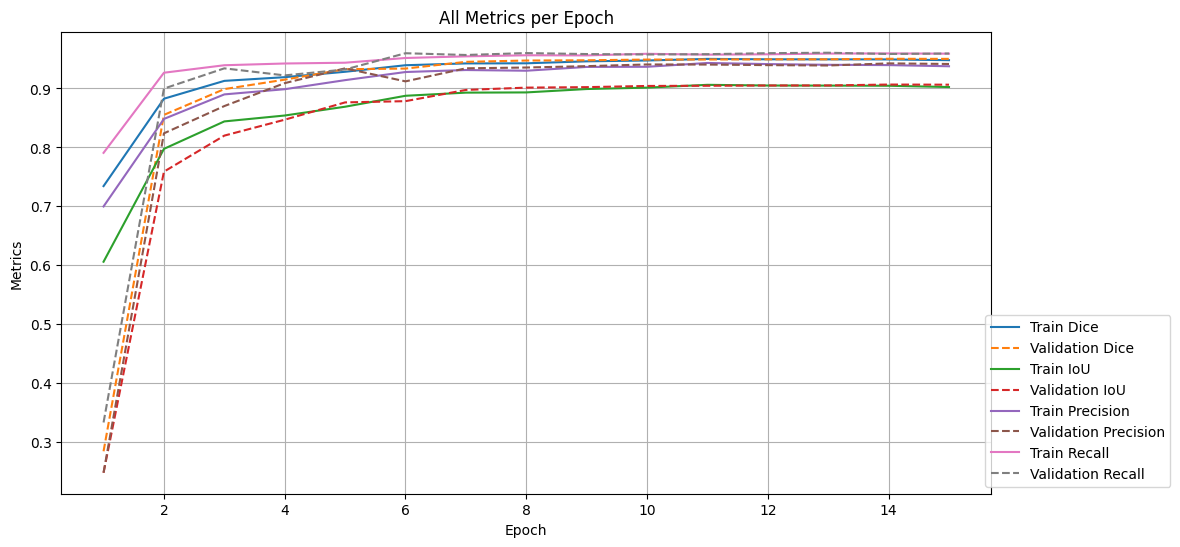

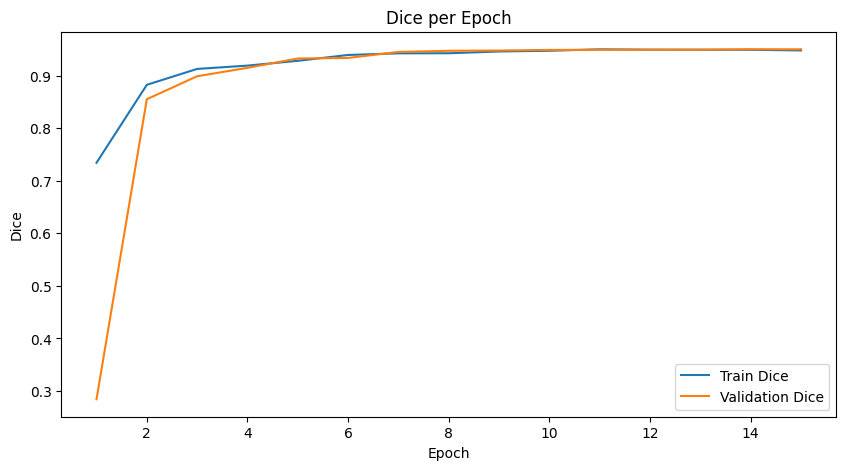

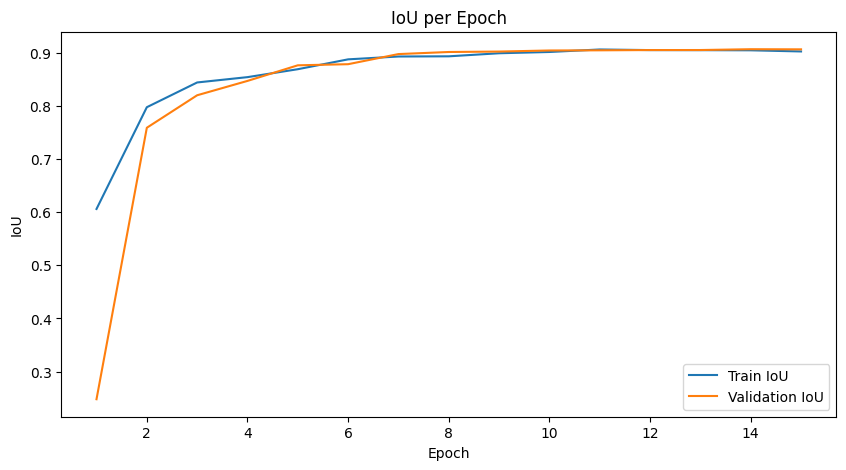

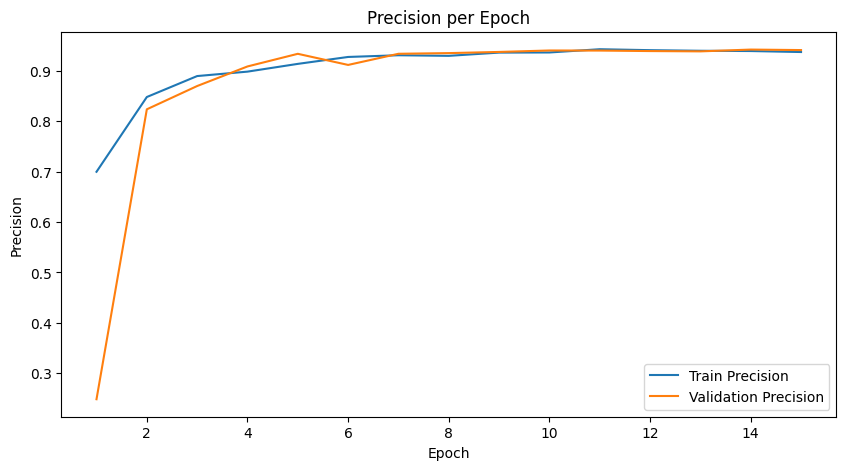

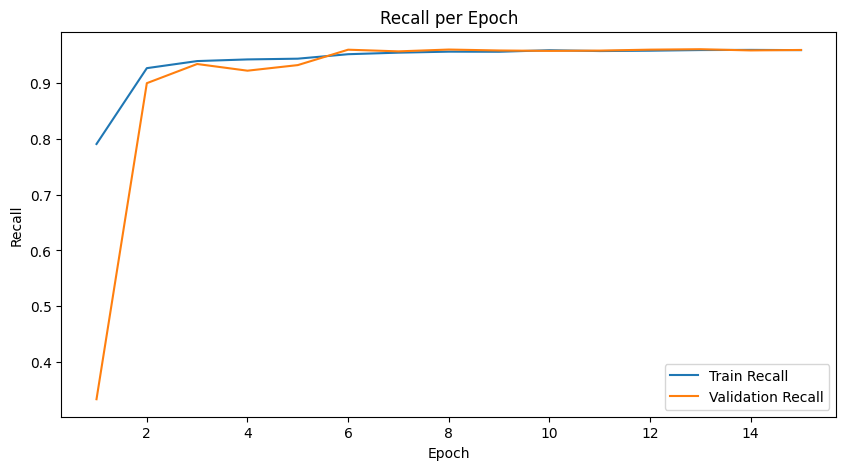

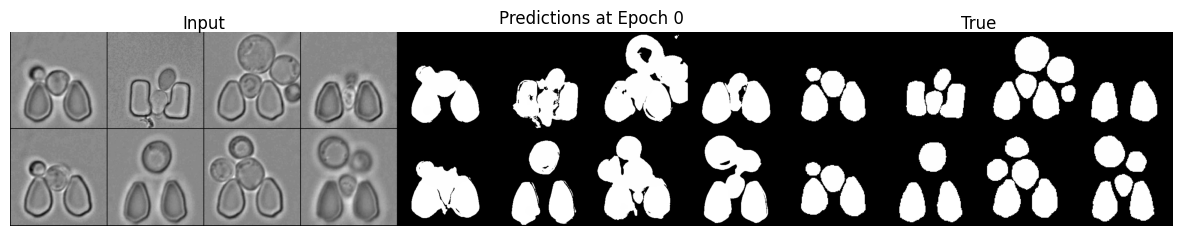

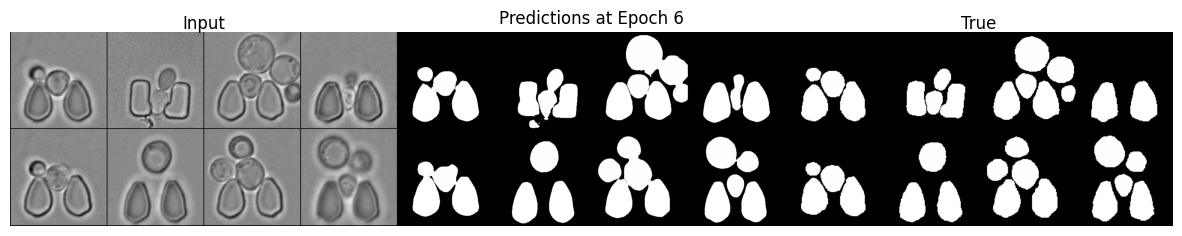

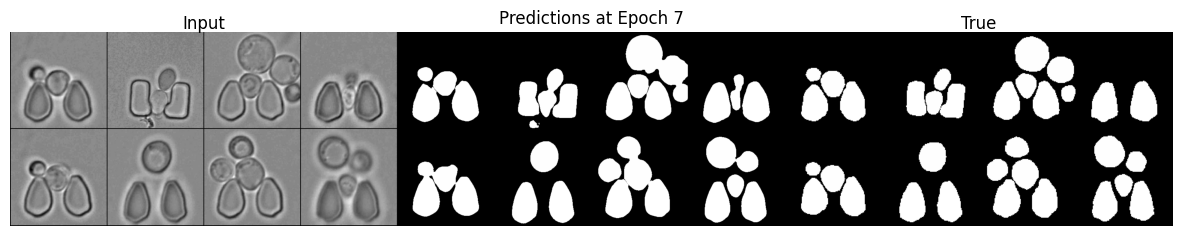

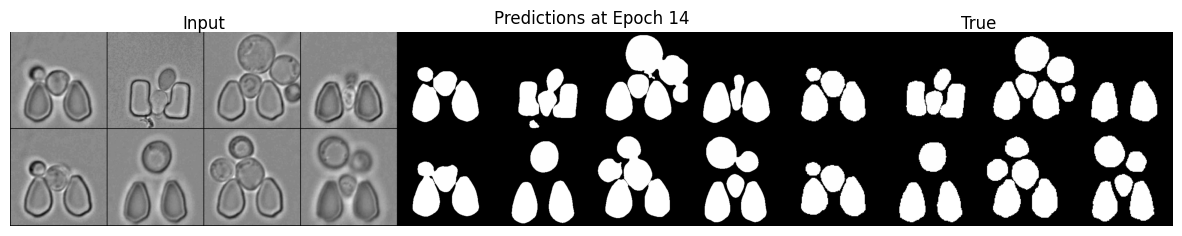

In [24]:
import torch
import torch.nn.functional as F

def soft_dice_loss(y_true, y_pred, epsilon=1e-6):
    '''
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_first` format.

    # Arguments
        y_true: b x c x X x Y( x Z...) One hot encoding of ground truth
        y_pred: b x c x X x Y( x Z...) Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    '''
    # Convert y_true to one-hot encoding if it's not already
    if y_true.ndim == y_pred.ndim - 1:
        y_true = F.one_hot(y_true, num_classes=y_pred.shape[1]).permute(0, 3, 1, 2).float()
    else:
        y_true = y_true.float()
    
    # Apply softmax to y_pred to get probabilities
    y_pred = F.softmax(y_pred, dim=1)
    
    # Flatten the tensors to calculate Dice loss
    axes = tuple(range(2, len(y_pred.shape)))  # Skip batch and class axes
    numerator = 2. * torch.sum(y_pred * y_true, dim=axes)
    denominator = torch.sum(y_pred ** 2 + y_true ** 2, dim=axes)
    
    dice_score = (numerator + epsilon) / (denominator + epsilon)
    dice_loss = 1 - dice_score
    
    # Average over classes and batch
    return dice_loss.mean()


class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float, num_classes: int):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        self.train_metrics = create_segmentation_metrics(num_classes=self.num_classes)
        self.val_metrics = create_segmentation_metrics(num_classes=self.num_classes)

        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.train_epoch_metrics = {k: [] for k in self.train_metrics.keys()}
        self.val_epoch_metrics = {k: [] for k in self.val_metrics.keys()}

        self.val_examples = (None, None, None)  

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = soft_dice_loss(masks, logits)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        preds = logits.argmax(dim=1)
        self.train_metrics.update(preds, masks)

        return loss



    def on_train_epoch_end(self):
        metrics = self.train_metrics.compute()
        for k, v in metrics.items():
            self.log(f'train_{k}', v, on_step=False, on_epoch=True)
            self.train_epoch_metrics[k].append(v.cpu().detach().numpy())
        self.train_metrics.reset()

        avg_loss = self.trainer.callback_metrics.get('train_loss', torch.tensor(0.0)).item()
        self.train_epoch_losses.append(avg_loss)

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = soft_dice_loss(masks, logits)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        preds = logits.argmax(dim=1)
        self.val_metrics.update(preds, masks)

        if batch_idx == 0:
            self.val_examples = (images.cpu(), preds.cpu(), masks.cpu())

        return loss

    def on_validation_epoch_end(self):
        metrics = self.val_metrics.compute()
        for k, v in metrics.items():
            self.log(f'val_{k}', v, on_step=False, on_epoch=True)
            self.val_epoch_metrics[k].append(v.cpu().detach().numpy())
        self.val_metrics.reset()

        avg_loss = self.trainer.callback_metrics.get('val_loss', torch.tensor(0.0)).item()
        self.val_epoch_losses.append(avg_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[5, 10, 15], gamma=0.1
        )
        return [optimizer], [scheduler]

from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

torch.manual_seed(42)

datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)
datamodule.setup("fit")

model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)

lit_model = Lit(
    model=model,
    learning_rate=0.001,
    num_classes=3
)

logger = CSVLogger(save_dir='logs/', name='segmentation_model')

checkpoint_dice = ModelCheckpoint(
    monitor="val_Dice",
    mode="max",
    save_top_k=5,
    filename="best-dice-{epoch}",
    verbose=True
)

checkpoint_iou = ModelCheckpoint(
    monitor="val_IoU",
    mode="max",
    save_top_k=5,
    filename="best-iou-{epoch}",
    verbose=True
)

save_preds_callback = SavePredictionExamplesCallback(num_samples=8, save_dir='validation_examples')

trainer = L.Trainer(
    accelerator='auto',
    max_epochs=15,
    logger=logger,
    callbacks=[checkpoint_dice, checkpoint_iou, save_preds_callback],
)

trainer.fit(
    model=lit_model,
    datamodule=datamodule,
)

import matplotlib.pyplot as plt
from PIL import Image

def plot_metrics(lit_model):
    num_epochs = len(lit_model.train_epoch_losses)  
    epochs = range(1, num_epochs + 1)  
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lit_model.train_epoch_losses, label='Train Loss')
    plt.plot(epochs, lit_model.val_epoch_losses[:num_epochs], label='Validation Loss')  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    for metric in lit_model.train_epoch_metrics.keys():
        plt.plot(epochs, lit_model.train_epoch_metrics[metric], label=f'Train {metric}')
        plt.plot(epochs, lit_model.val_epoch_metrics[metric][:num_epochs], label=f'Validation {metric}', linestyle='--')  
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title('All Metrics per Epoch')
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0))
    plt.grid(True)
    plt.show()
    
    for metric in lit_model.train_epoch_metrics.keys():
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, lit_model.train_epoch_metrics[metric], label=f'Train {metric}')
        plt.plot(epochs, lit_model.val_epoch_metrics[metric][:num_epochs], label=f'Validation {metric}')  
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} per Epoch')
        plt.legend()
        plt.show()

plot_metrics(lit_model)
def display_prediction_examples(epochs_list, save_dir='validation_examples'):
    for epoch in epochs_list:
        image_path = os.path.join(save_dir, f'epoch_{epoch}.png')
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.figure(figsize=(15, 5))
            plt.axis('off')
            plt.title(f'Predictions at Epoch {epoch}')
            plt.imshow(img)
            img_width = img.width
            plt.text(img_width / 6, -10, 'Input', ha='center', fontsize=12) 
            #plt.text(img_width / 2, -10, 'Predicted', ha='center', fontsize=12)
            plt.text(img_width * 5 / 6, -10, 'True', ha='center', fontsize=12)
            
            plt.show()
        else:
            print(f'Image for epoch {epoch} not found.')

total_epochs = len(lit_model.train_epoch_losses)
mid_epoch = total_epochs // 2
epochs_to_display = [0, mid_epoch - 1, mid_epoch, total_epochs - 1]
epochs_to_display = [epoch for epoch in epochs_to_display if epoch < total_epochs]
display_prediction_examples(epochs_to_display)

### Задание 4 (3 балла). Модификация архитектуры

Ваша задача - извлечь максимальную точность из модели, в которой будет не более 50k параметров. Для этого внесите правки в архитектуру модели.

В частности, попробуйте заменить в блоке `Down` комбинацию conv+maxpool на dilated conv (`nn.Conv2d(..., dilation=2)`). В остальном - полная свобода творчества, можете перерабатывать архитектуру как угодно.

Как обычно, запустите эксперимент (или несколько) с выводом всех графиков и картинок.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 46.5 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
46.5 K    Trainable params
0         Non-trainable params
46.5 K    Total params
0.186     Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Saved prediction examples for epoch 0 at validation_examples/epoch_0.png


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 37: 'val_Dice' reached 0.68659 (best 0.68659), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=0.ckpt' as top 5
Epoch 0, global step 37: 'val_IoU' reached 0.55569 (best 0.55569), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=0.ckpt' as top 5


Saved prediction examples for epoch 0 at validation_examples/epoch_0.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 74: 'val_Dice' reached 0.80154 (best 0.80154), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=1.ckpt' as top 5
Epoch 1, global step 74: 'val_IoU' reached 0.68862 (best 0.68862), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=1.ckpt' as top 5


Saved prediction examples for epoch 1 at validation_examples/epoch_1.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 111: 'val_Dice' reached 0.84608 (best 0.84608), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=2.ckpt' as top 5
Epoch 2, global step 111: 'val_IoU' reached 0.74532 (best 0.74532), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=2.ckpt' as top 5


Saved prediction examples for epoch 2 at validation_examples/epoch_2.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 148: 'val_Dice' reached 0.88960 (best 0.88960), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=3.ckpt' as top 5
Epoch 3, global step 148: 'val_IoU' reached 0.80730 (best 0.80730), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=3.ckpt' as top 5


Saved prediction examples for epoch 3 at validation_examples/epoch_3.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 185: 'val_Dice' reached 0.88130 (best 0.88960), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=4.ckpt' as top 5
Epoch 4, global step 185: 'val_IoU' reached 0.79761 (best 0.80730), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=4.ckpt' as top 5


Saved prediction examples for epoch 4 at validation_examples/epoch_4.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 222: 'val_Dice' reached 0.92019 (best 0.92019), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=5.ckpt' as top 5
Epoch 5, global step 222: 'val_IoU' reached 0.85665 (best 0.85665), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=5.ckpt' as top 5


Saved prediction examples for epoch 5 at validation_examples/epoch_5.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 259: 'val_Dice' reached 0.92343 (best 0.92343), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=6.ckpt' as top 5
Epoch 6, global step 259: 'val_IoU' reached 0.86169 (best 0.86169), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=6.ckpt' as top 5


Saved prediction examples for epoch 6 at validation_examples/epoch_6.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 296: 'val_Dice' reached 0.92651 (best 0.92651), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=7.ckpt' as top 5
Epoch 7, global step 296: 'val_IoU' reached 0.86681 (best 0.86681), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=7.ckpt' as top 5


Saved prediction examples for epoch 7 at validation_examples/epoch_7.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 333: 'val_Dice' reached 0.92548 (best 0.92651), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=8.ckpt' as top 5
Epoch 8, global step 333: 'val_IoU' reached 0.86508 (best 0.86681), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=8.ckpt' as top 5


Saved prediction examples for epoch 8 at validation_examples/epoch_8.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 370: 'val_Dice' reached 0.92727 (best 0.92727), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=9.ckpt' as top 5
Epoch 9, global step 370: 'val_IoU' reached 0.86800 (best 0.86800), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=9.ckpt' as top 5


Saved prediction examples for epoch 9 at validation_examples/epoch_9.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 407: 'val_Dice' reached 0.92837 (best 0.92837), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=10.ckpt' as top 5
Epoch 10, global step 407: 'val_IoU' reached 0.86981 (best 0.86981), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=10.ckpt' as top 5


Saved prediction examples for epoch 10 at validation_examples/epoch_10.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 444: 'val_Dice' reached 0.92844 (best 0.92844), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=11.ckpt' as top 5
Epoch 11, global step 444: 'val_IoU' reached 0.86995 (best 0.86995), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=11.ckpt' as top 5


Saved prediction examples for epoch 11 at validation_examples/epoch_11.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 481: 'val_Dice' reached 0.92857 (best 0.92857), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=12.ckpt' as top 5
Epoch 12, global step 481: 'val_IoU' reached 0.87011 (best 0.87011), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=12.ckpt' as top 5


Saved prediction examples for epoch 12 at validation_examples/epoch_12.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 518: 'val_Dice' reached 0.92865 (best 0.92865), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=13.ckpt' as top 5
Epoch 13, global step 518: 'val_IoU' reached 0.87025 (best 0.87025), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=13.ckpt' as top 5


Saved prediction examples for epoch 13 at validation_examples/epoch_13.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 555: 'val_Dice' reached 0.92857 (best 0.92865), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=14.ckpt' as top 5
Epoch 14, global step 555: 'val_IoU' reached 0.87014 (best 0.87025), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=14.ckpt' as top 5


Saved prediction examples for epoch 14 at validation_examples/epoch_14.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 592: 'val_Dice' reached 0.92884 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=15.ckpt' as top 5
Epoch 15, global step 592: 'val_IoU' reached 0.87054 (best 0.87054), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=15.ckpt' as top 5


Saved prediction examples for epoch 15 at validation_examples/epoch_15.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 629: 'val_Dice' reached 0.92848 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=16.ckpt' as top 5
Epoch 16, global step 629: 'val_IoU' was not in top 5


Saved prediction examples for epoch 16 at validation_examples/epoch_16.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 666: 'val_Dice' reached 0.92855 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=17.ckpt' as top 5
Epoch 17, global step 666: 'val_IoU' reached 0.87006 (best 0.87054), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=17.ckpt' as top 5


Saved prediction examples for epoch 17 at validation_examples/epoch_17.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 703: 'val_Dice' reached 0.92880 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=18.ckpt' as top 5
Epoch 18, global step 703: 'val_IoU' reached 0.87047 (best 0.87054), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=18.ckpt' as top 5


Saved prediction examples for epoch 18 at validation_examples/epoch_18.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 740: 'val_Dice' was not in top 5
Epoch 19, global step 740: 'val_IoU' was not in top 5


Saved prediction examples for epoch 19 at validation_examples/epoch_19.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 777: 'val_Dice' reached 0.92871 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=20.ckpt' as top 5
Epoch 20, global step 777: 'val_IoU' reached 0.87032 (best 0.87054), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=20.ckpt' as top 5


Saved prediction examples for epoch 20 at validation_examples/epoch_20.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 814: 'val_Dice' reached 0.92867 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=21.ckpt' as top 5
Epoch 21, global step 814: 'val_IoU' reached 0.87028 (best 0.87054), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=21.ckpt' as top 5


Saved prediction examples for epoch 21 at validation_examples/epoch_21.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 851: 'val_Dice' reached 0.92883 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=22.ckpt' as top 5
Epoch 22, global step 851: 'val_IoU' reached 0.87052 (best 0.87054), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=22.ckpt' as top 5


Saved prediction examples for epoch 22 at validation_examples/epoch_22.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 888: 'val_Dice' was not in top 5
Epoch 23, global step 888: 'val_IoU' was not in top 5


Saved prediction examples for epoch 23 at validation_examples/epoch_23.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 925: 'val_Dice' reached 0.92879 (best 0.92884), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=24.ckpt' as top 5
Epoch 24, global step 925: 'val_IoU' reached 0.87047 (best 0.87054), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=24.ckpt' as top 5


Saved prediction examples for epoch 24 at validation_examples/epoch_24.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 962: 'val_Dice' reached 0.92888 (best 0.92888), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=25.ckpt' as top 5
Epoch 25, global step 962: 'val_IoU' reached 0.87061 (best 0.87061), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=25.ckpt' as top 5


Saved prediction examples for epoch 25 at validation_examples/epoch_25.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 999: 'val_Dice' was not in top 5
Epoch 26, global step 999: 'val_IoU' was not in top 5


Saved prediction examples for epoch 26 at validation_examples/epoch_26.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1036: 'val_Dice' was not in top 5
Epoch 27, global step 1036: 'val_IoU' was not in top 5


Saved prediction examples for epoch 27 at validation_examples/epoch_27.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1073: 'val_Dice' was not in top 5
Epoch 28, global step 1073: 'val_IoU' was not in top 5


Saved prediction examples for epoch 28 at validation_examples/epoch_28.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1110: 'val_Dice' was not in top 5
Epoch 29, global step 1110: 'val_IoU' was not in top 5


Saved prediction examples for epoch 29 at validation_examples/epoch_29.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1147: 'val_Dice' was not in top 5
Epoch 30, global step 1147: 'val_IoU' was not in top 5


Saved prediction examples for epoch 30 at validation_examples/epoch_30.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 1184: 'val_Dice' reached 0.92887 (best 0.92888), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=31.ckpt' as top 5
Epoch 31, global step 1184: 'val_IoU' reached 0.87059 (best 0.87061), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=31.ckpt' as top 5


Saved prediction examples for epoch 31 at validation_examples/epoch_31.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 1221: 'val_Dice' was not in top 5
Epoch 32, global step 1221: 'val_IoU' was not in top 5


Saved prediction examples for epoch 32 at validation_examples/epoch_32.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1258: 'val_Dice' reached 0.92885 (best 0.92888), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=33.ckpt' as top 5


Saved prediction examples for epoch 33 at validation_examples/epoch_33.png


Epoch 33, global step 1258: 'val_IoU' reached 0.87055 (best 0.87061), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=33.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 1295: 'val_Dice' was not in top 5
Epoch 34, global step 1295: 'val_IoU' was not in top 5


Saved prediction examples for epoch 34 at validation_examples/epoch_34.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 1332: 'val_Dice' reached 0.92888 (best 0.92888), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=35.ckpt' as top 5
Epoch 35, global step 1332: 'val_IoU' reached 0.87061 (best 0.87061), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=35.ckpt' as top 5


Saved prediction examples for epoch 35 at validation_examples/epoch_35.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 1369: 'val_Dice' was not in top 5
Epoch 36, global step 1369: 'val_IoU' was not in top 5


Saved prediction examples for epoch 36 at validation_examples/epoch_36.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 1406: 'val_Dice' reached 0.92896 (best 0.92896), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=37.ckpt' as top 5
Epoch 37, global step 1406: 'val_IoU' reached 0.87074 (best 0.87074), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=37.ckpt' as top 5


Saved prediction examples for epoch 37 at validation_examples/epoch_37.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 1443: 'val_Dice' reached 0.92889 (best 0.92896), saving model to 'logs/segmentation_model/version_27/checkpoints/best-dice-epoch=38.ckpt' as top 5
Epoch 38, global step 1443: 'val_IoU' reached 0.87063 (best 0.87074), saving model to 'logs/segmentation_model/version_27/checkpoints/best-iou-epoch=38.ckpt' as top 5


Saved prediction examples for epoch 38 at validation_examples/epoch_38.png


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 1480: 'val_Dice' was not in top 5
Epoch 39, global step 1480: 'val_IoU' was not in top 5
`Trainer.fit` stopped: `max_epochs=40` reached.


Saved prediction examples for epoch 39 at validation_examples/epoch_39.png


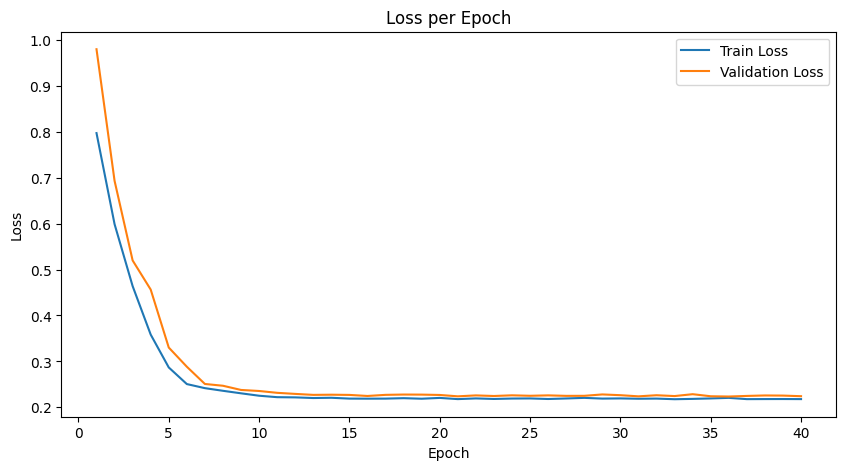

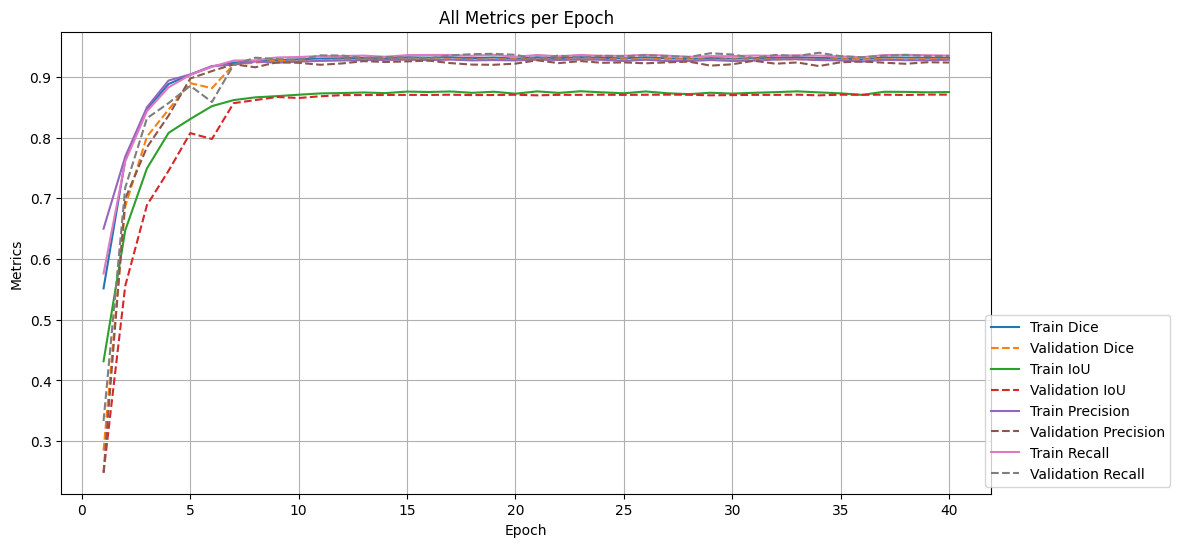

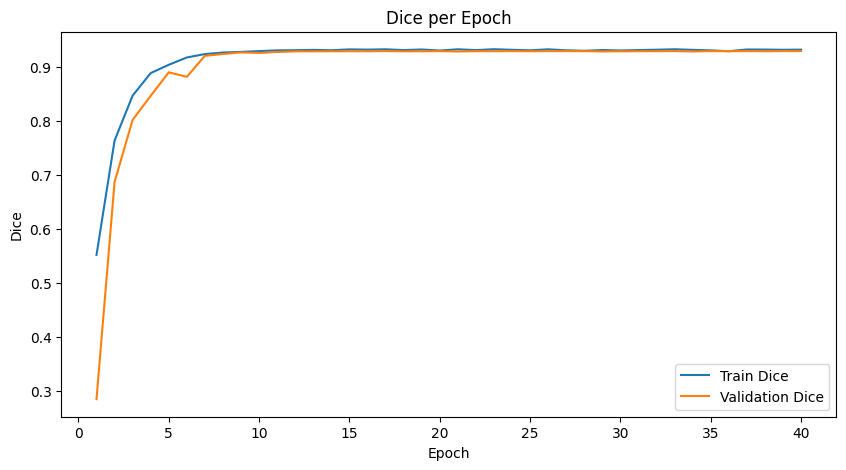

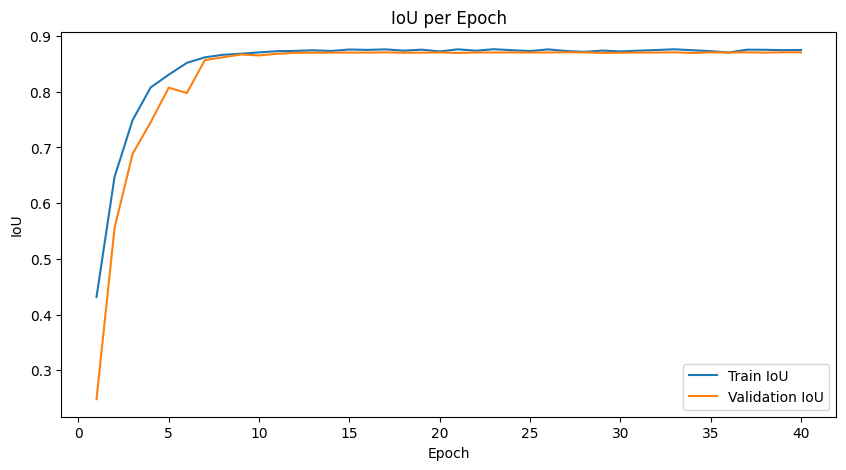

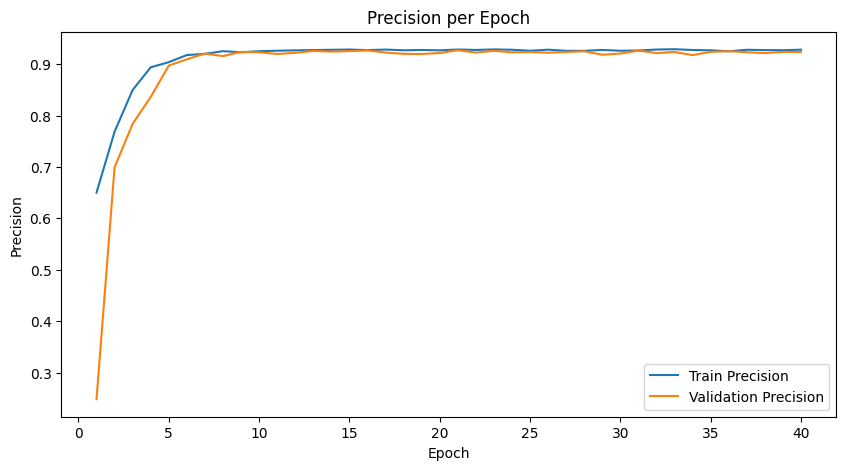

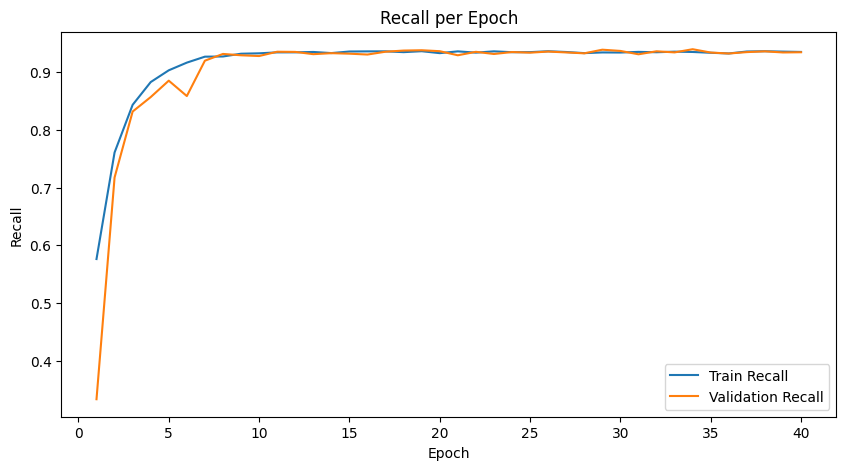

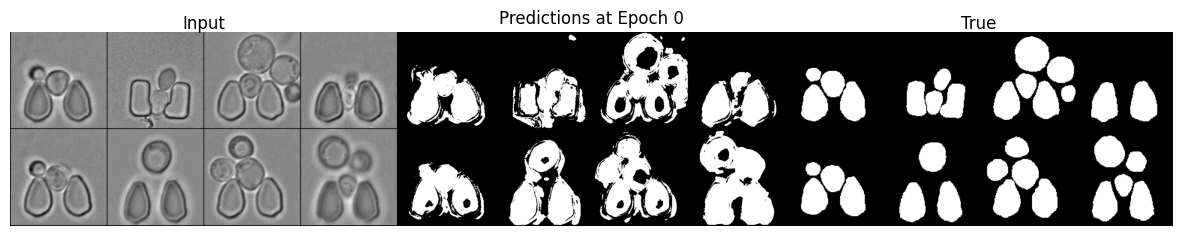

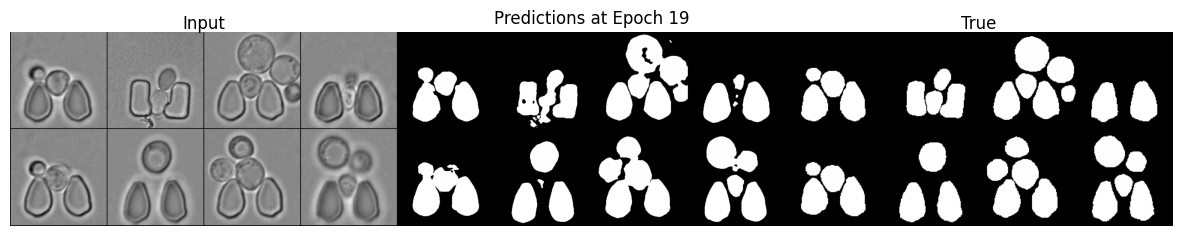

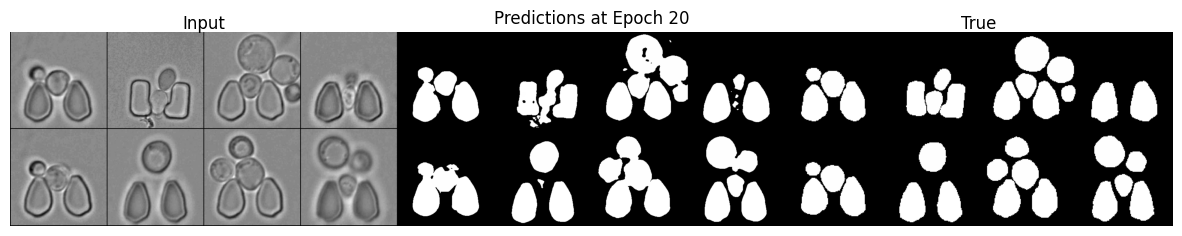

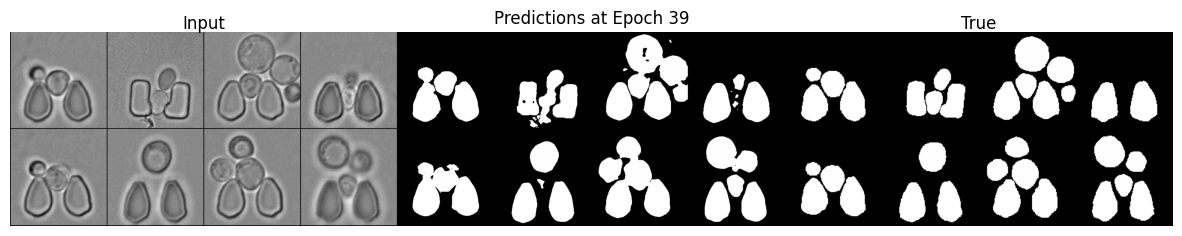

In [6]:

# Определение модели U-Net
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
            self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int, dilation: int = 2) -> None:
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,  # Уменьшение размерности аналогично MaxPool2d(2)
            padding=2,
            dilation=2,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
            self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
            self,
            n_channels: int,
            n_classes: int,
            channel_sizes: list[int],
            bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
            cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                channel_sizes[:-1], channel_sizes[1:], down_factors
            )
            ]
        )

    @classmethod
    def create_upscaler(
            cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
            )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits


from torchmetrics import MetricCollection


#from torchmetrics import JaccardIndex# Коэффициент перекрытия (Intersection over Union, IoU)
#from torchmetrics import Dice # Коэффициент Дайса (Dice Coefficient)
#from torchmetrics import Recall # Полнота (Recall)
#from torchmetrics import Precision # Точность (Precision)
def create_segmentation_metrics(num_classes: int):
    return MetricCollection({
        "IoU": JaccardIndex(task="multiclass", num_classes=num_classes),
        "Dice": Dice(num_classes=num_classes, average="macro"),
        "Precision": Precision(task="multiclass", num_classes=num_classes, average="macro"),
        "Recall": Recall(task="multiclass", num_classes=num_classes, average="macro"),
    })


torch.manual_seed(42)

from torchmetrics import MetricCollection, JaccardIndex, Dice, Precision, Recall
import lightning as L
import matplotlib.pyplot as plt
from PIL import Image
import os


class SavePredictionExamplesCallback(L.Callback):
    def __init__(self, num_samples: int = 8, save_dir: str = 'validation_examples'):
        super().__init__()
        self.num_samples = num_samples
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.transform = transforms.ToPILImage()

    def on_validation_epoch_end(self, trainer: L.Trainer, pl_module: L.LightningModule):
        images, preds, masks = getattr(pl_module, 'val_examples', (None, None, None))
        if images is None:
            return

        num_samples = min(self.num_samples, images.size(0))
        images = images[:num_samples]
        preds = preds[:num_samples]
        masks = masks[:num_samples]

        image_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
        preds_grid = torchvision.utils.make_grid(preds.unsqueeze(1).float(), nrow=4, normalize=False)
        masks_grid = torchvision.utils.make_grid(masks.unsqueeze(1).float(), nrow=4, normalize=False)

        image_grid = self.transform(image_grid)
        preds_grid = self.transform(preds_grid)
        masks_grid = self.transform(masks_grid)

        total_width = image_grid.width * 3
        max_height = image_grid.height
        combined_image = Image.new('RGB', (total_width, max_height))
        combined_image.paste(image_grid, (0, 0))
        combined_image.paste(preds_grid.convert('RGB'), (image_grid.width, 0))
        combined_image.paste(masks_grid.convert('RGB'), (image_grid.width * 2, 0))

        epoch = trainer.current_epoch
        output_path = os.path.join(self.save_dir, f'epoch_{epoch}.png')
        combined_image.save(output_path)
        print(f"Saved prediction examples for epoch {epoch} at {output_path}")


class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float, num_classes: int):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        self.train_metrics = create_segmentation_metrics(num_classes=self.num_classes)
        self.val_metrics = create_segmentation_metrics(num_classes=self.num_classes)

        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.train_epoch_metrics = {k: [] for k in self.train_metrics.keys()}
        self.val_epoch_metrics = {k: [] for k in self.val_metrics.keys()}

        self.val_examples = (None, None, None)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = F.cross_entropy(logits, masks)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        preds = logits.argmax(dim=1)
        self.train_metrics.update(preds, masks)

        return loss

    def on_train_epoch_end(self):
        metrics = self.train_metrics.compute()
        for k, v in metrics.items():
            self.log(f'train_{k}', v, on_step=False, on_epoch=True)
            self.train_epoch_metrics[k].append(v.cpu().detach().numpy())
        self.train_metrics.reset()

        avg_loss = self.trainer.callback_metrics.get('train_loss', torch.tensor(0.0)).item()
        self.train_epoch_losses.append(avg_loss)

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = F.cross_entropy(logits, masks)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        preds = logits.argmax(dim=1)
        self.val_metrics.update(preds, masks)

        if batch_idx == 0:
            self.val_examples = (images.cpu(), preds.cpu(), masks.cpu())

        return loss

    def on_validation_epoch_end(self):
        metrics = self.val_metrics.compute()
        for k, v in metrics.items():
            self.log(f'val_{k}', v, on_step=False, on_epoch=True)
            self.val_epoch_metrics[k].append(v.cpu().detach().numpy())
        self.val_metrics.reset()

        avg_loss = self.trainer.callback_metrics.get('val_loss', torch.tensor(0.0)).item()
        self.val_epoch_losses.append(avg_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[5, 10, 15], gamma=0.1
        )
        return [optimizer], [scheduler]


from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

torch.manual_seed(42)

datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)
datamodule.setup("fit")

model = UNet(n_channels=1, n_classes=3, channel_sizes=[8, 16, 32, 64], bilinear=True)

lit_model = Lit(
    model=model,
    learning_rate=1e-3,
    num_classes=3
)

logger = CSVLogger(save_dir='logs/', name='segmentation_model')

checkpoint_dice = ModelCheckpoint(
    monitor="val_Dice",
    mode="max",
    save_top_k=5,
    filename="best-dice-{epoch}",
    verbose=True
)

checkpoint_iou = ModelCheckpoint(
    monitor="val_IoU",
    mode="max",
    save_top_k=5,
    filename="best-iou-{epoch}",
    verbose=True
)

save_preds_callback = SavePredictionExamplesCallback(num_samples=8, save_dir='validation_examples')

trainer = L.Trainer(
    accelerator='auto',
    max_epochs=40,
    logger=logger,
    callbacks=[checkpoint_dice, checkpoint_iou, save_preds_callback],
)

trainer.fit(
    model=lit_model,
    datamodule=datamodule,
)

import matplotlib.pyplot as plt
from PIL import Image


def plot_metrics(lit_model):
    num_epochs = len(lit_model.train_epoch_losses)
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lit_model.train_epoch_losses, label='Train Loss')
    plt.plot(epochs, lit_model.val_epoch_losses[:num_epochs], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    for metric in lit_model.train_epoch_metrics.keys():
        plt.plot(epochs, lit_model.train_epoch_metrics[metric], label=f'Train {metric}')
        plt.plot(epochs, lit_model.val_epoch_metrics[metric][:num_epochs], label=f'Validation {metric}', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title('All Metrics per Epoch')
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0))
    plt.grid(True)
    plt.show()

    for metric in lit_model.train_epoch_metrics.keys():
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, lit_model.train_epoch_metrics[metric], label=f'Train {metric}')
        plt.plot(epochs, lit_model.val_epoch_metrics[metric][:num_epochs], label=f'Validation {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} per Epoch')
        plt.legend()
        plt.show()


plot_metrics(lit_model)


def display_prediction_examples(epochs_list, save_dir='validation_examples'):
    for epoch in epochs_list:
        image_path = os.path.join(save_dir, f'epoch_{epoch}.png')
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.figure(figsize=(15, 5))
            plt.axis('off')
            plt.title(f'Predictions at Epoch {epoch}')
            plt.imshow(img)
            img_width = img.width
            plt.text(img_width / 6, -10, 'Input', ha='center', fontsize=12)
            #plt.text(img_width / 2, -10, 'Predicted', ha='center', fontsize=12)
            plt.text(img_width * 5 / 6, -10, 'True', ha='center', fontsize=12)

            plt.show()
        else:
            print(f'Image for epoch {epoch} not found.')


total_epochs = len(lit_model.train_epoch_losses)
mid_epoch = total_epochs // 2
epochs_to_display = [0, mid_epoch - 1, mid_epoch, total_epochs - 1]
epochs_to_display = [epoch for epoch in epochs_to_display if epoch < total_epochs]
display_prediction_examples(epochs_to_display)

In [7]:
from functools import lru_cache

def calculate_probability():
    @lru_cache(maxsize=None)
    def P(r, c, f):
        # Если текущая серия орлов достаточна для победы
        if c >= r:
            return 1.0
        # Если бросков не осталось
        if f == 0:
            return 0.0
        # Вероятность выпадения орла
        prob_heads = 0.5 * P(r, c + 1, f - 1)
        # Вероятность выпадения решки
        prob_tails = 0.5 * P(r + 1, 0, f - 1)
        return prob_heads + prob_tails

    # Начальное состояние: требуется 2 орла, текущая серия 0, 10 бросков
    probability = P(2, 0, 10)
    return probability

# Вычислим вероятность и выведем результат с точностью до 4 знаков после запятой
prob = calculate_probability()
print(f"{prob:.4f}")

0.4004
